In [ ]:
pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00


In [1]:
import os
import wandb
import torch
import pandas as pd
import evaluate
import numpy as np
from transformers import (
    AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [17]:
# === Загрузка данных ===
data_path = "data/reranker_dataset.pkl"
df = pd.read_pickle(data_path)

# === Настройка wandb ===
wandb.init(project="CrossEncoder_Optimized", name="training_run", sync_tensorboard=True)


# === Загрузка модели и токенизатора ===
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
df

,combined,label
0,"29 year old female, first seizure one month ag...",1
1,Protein markers for the three most prevalent b...,1
2,No environmental factors. [SEP] And shes not r...,1
3,Isnt treating Patients why we became doctors? ...,1
4,"Aneurysm, stroke, or some other ischemic syndr...",1
...,...,...
14829,"Hold your Parkld. [SEP] If it couldve been, yo...",0
14830,I dont hate you. [SEP] I love you. [SEP] But n...,0
14831,moment with the Patient! [SEP] the chunk of th...,0
14832,"Let me take the fall. [SEP] For you, for that ...",0


In [3]:
# === Конфигурация модели с Dropout ===
config = AutoConfig.from_pretrained(
    model_name,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

# === Создание модели ===
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


# === Метрики ===
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    acc_result = accuracy.compute(predictions=preds, references=eval_pred.label_ids)
    f1_result = f1.compute(predictions=preds, references=eval_pred.label_ids, average="weighted")
    return {"accuracy": acc_result["accuracy"], "f1": f1_result["f1"]}

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import EarlyStoppingCallback

# === Разделение на train/valid ===
df_train, df_valid = train_test_split(df, test_size=0.15, random_state=42)

# === Создание DatasetDict для Hugging Face ===
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
})

# === Токенизация ===
def preprocess_data(examples):
    return tokenizer(examples["combined"], truncation=True, max_length=512)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
encoded_dataset = dataset.map(preprocess_data, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")

from transformers import EarlyStoppingCallback

# === Настройки обучения с early stopping ===
training_args = TrainingArguments(
    output_dir="CrossEncoder_Optimized",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-6,
    weight_decay=0.05,  # Увеличиваем L2-регуляризацию
    num_train_epochs=10,  # До 10, но остановим раньше
    warmup_ratio=0.05,
    optim="adamw_torch",
    lr_scheduler_type="reduce_lr_on_plateau",  # Новый планировщик скорости обучения
    logging_dir="./wandb",
    logging_steps=50,
    report_to="wandb",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,
)

Map:   0%|          | 0/12608 [00:00<?, ? examples/s]

Map:   0%|          | 0/2226 [00:00<?, ? examples/s]

In [10]:
# === Обучение модели ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Остановка после 3 эпох без улучшения
)

# === Оценка модели перед обучением ===
eval_results = trainer.evaluate()
print("\nПоказатели модели перед обучением:")
for key, value in eval_results.items():
    print(f"{key}: {value:.6f}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



Показатели модели перед обучением:
eval_loss: 0.693659
eval_model_preparation_time: 0.003200
eval_accuracy: 0.513926
eval_f1: 0.348921
eval_runtime: 8.356500
eval_samples_per_second: 266.378000
eval_steps_per_second: 8.377000


In [11]:
# === Запуск обучения ===
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.682200,0.595012,0.003200,0.724169,0.708728
2,0.463300,0.361416,0.003200,0.893980,0.894000
3,0.272600,0.297882,0.003200,0.896226,0.896161
4,0.196900,0.293931,0.003200,0.905660,0.905390


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.682200,0.595012,0.003200,0.724169,0.708728
2,0.463300,0.361416,0.003200,0.893980,0.894000
3,0.272600,0.297882,0.003200,0.896226,0.896161
4,0.196900,0.293931,0.003200,0.905660,0.905390
5,0.183600,0.244622,0.003200,0.925427,0.925317
6,0.134800,0.189461,0.003200,0.945193,0.945197
7,0.113100,0.190104,0.003200,0.950584,0.950586
8,0.101900,0.227839,0.003200,0.942947,0.942902
9,0.099800,0.230107,0.003200,0.949686,0.949675


TrainOutput(global_step=1773, training_loss=0.2599372988828346, metrics={'train_runtime': 1371.902, 'train_samples_per_second': 91.902, 'train_steps_per_second': 1.436, 'total_flos': 1.178643554153856e+16, 'train_loss': 0.2599372988828346, 'epoch': 9.0})

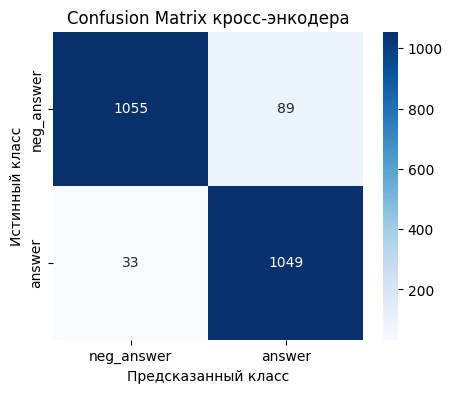

In [13]:
# Оценка модели на валидации
eval_preds = trainer.predict(encoded_dataset["valid"])
preds = np.argmax(eval_preds.predictions, axis=1)
true_labels = eval_preds.label_ids

# Вычисление матрицы ошибок
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg_answer", "answer"], yticklabels=["neg_answer", "answer"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion Matrix кросс-энкодера")
plt.show()

In [14]:
# === Сохранение модели ===
model.save_pretrained("CrossEncoder_Optimized")
tokenizer.save_pretrained("CrossEncoder_Optimized")

print("Обучение завершено!")

wandb.finish()

Обучение завершено!


eval/accuracy,▁▄▇▇▇█████
eval/f1,▁▅▇▇▇█████
eval/loss,█▇▃▃▂▂▁▁▂▂
eval/model_preparation_time,▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁█████████
eval/steps_per_second,▁█████████
test/accuracy,▁▁
test/f1,▁▁
test/loss,▁▁
test/model_preparation_time,▁▁


In [15]:
# Загрузка в Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()

In [16]:
# Сохранение модели локально
model_path = "/content/RerankerModel_chat_bot"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

model.push_to_hub("nikatonika/chatbot_reranker")
tokenizer.push_to_hub("nikatonika/chatbot_reranker")

print("Модель кросс-энкодера загружена в Hugging Face Hub!")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Модель кросс-энкодера загружена в Hugging Face Hub!


In [19]:
import shutil
from google.colab import files

# Упаковываем логи в zip
shutil.make_archive("logs", 'zip', "./wandb")

# Скачиваем архив
files.download("logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>